In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import IPython
import IPython.display

# Load Dataset & Dataset Visualization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change directory
os.chdir('/content/drive/MyDrive/advanced data mining/assignment1')

In [ ]:
train_df = pd.read_csv("train.csv")
train_df.tail()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8
7110,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1.4,4.1,186.5


In [ ]:
train_df.describe()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000
mean,20.878034,47.561004,1.110309,1091.572100,938.064970,883.903305,1513.238349,998.335565,2.086219,10.237083,204.066784
std,7.937917,17.398731,0.398950,218.537554,281.978988,310.456355,350.180310,381.537695,1.447109,7.694426,193.927723
min,1.300000,8.900000,0.198800,620.300000,364.000000,310.600000,552.900000,242.700000,0.100000,0.100000,1.900000
25%,14.900000,33.700000,0.855900,930.250000,734.900000,681.050000,1320.350000,722.850000,1.000000,4.500000,76.450000
50%,20.700000,47.300000,1.083500,1060.500000,914.200000,827.800000,1513.100000,928.700000,1.700000,8.500000,141.000000
75%,25.800000,60.800000,1.404150,1215.800000,1124.100000,1008.850000,1720.400000,1224.700000,2.800000,14.200000,260.000000
max,46.100000,90.800000,2.231000,2088.300000,2302.600000,2567.400000,2913.800000,2594.600000,12.500000,63.700000,1472.300000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7111 entries, 0 to 7110
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_time               7111 non-null   object 
 1   deg_C                   7111 non-null   float64
 2   relative_humidity       7111 non-null   float64
 3   absolute_humidity       7111 non-null   float64
 4   sensor_1                7111 non-null   float64
 5   sensor_2                7111 non-null   float64
 6   sensor_3                7111 non-null   float64
 7   sensor_4                7111 non-null   float64
 8   sensor_5                7111 non-null   float64
 9   target_carbon_monoxide  7111 non-null   float64
 10  target_benzene          7111 non-null   float64
 11  target_nitrogen_oxides  7111 non-null   float64
dtypes: float64(11), object(1)
memory usage: 666.8+ KB


In [ ]:
# it seems like last row of training data is the same as first row of testing data
test_df = pd.read_csv("test.csv")
test_df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [ ]:
test_df.describe()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000
mean,10.808144,51.031242,0.627053,1106.534490,836.459769,828.321495,1104.850601,1029.851535
std,6.444497,16.665047,0.266588,205.341455,272.816585,339.511779,293.112225,434.863287
min,-1.800000,9.800000,0.184700,665.900000,356.200000,320.100000,523.400000,218.800000
25%,5.600000,36.900000,0.413350,951.500000,640.700000,597.050000,899.450000,688.550000
50%,9.800000,50.600000,0.596400,1080.400000,800.800000,757.100000,1076.200000,973.100000
75%,14.200000,63.550000,0.804950,1222.100000,1016.100000,944.950000,1288.350000,1324.000000
max,30.900000,88.800000,1.393000,1882.900000,1776.100000,1975.000000,2211.400000,2593.800000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          2247 non-null   object 
 1   deg_C              2247 non-null   float64
 2   relative_humidity  2247 non-null   float64
 3   absolute_humidity  2247 non-null   float64
 4   sensor_1           2247 non-null   float64
 5   sensor_2           2247 non-null   float64
 6   sensor_3           2247 non-null   float64
 7   sensor_4           2247 non-null   float64
 8   sensor_5           2247 non-null   float64
dtypes: float64(8), object(1)
memory usage: 158.1+ KB


### Concatenate both train and test set for making tf.Datasets later

In [ ]:
all_df = pd.concat([train_df, test_df[1:]]).reset_index(drop=True)

### Plot the time series data for trend overview

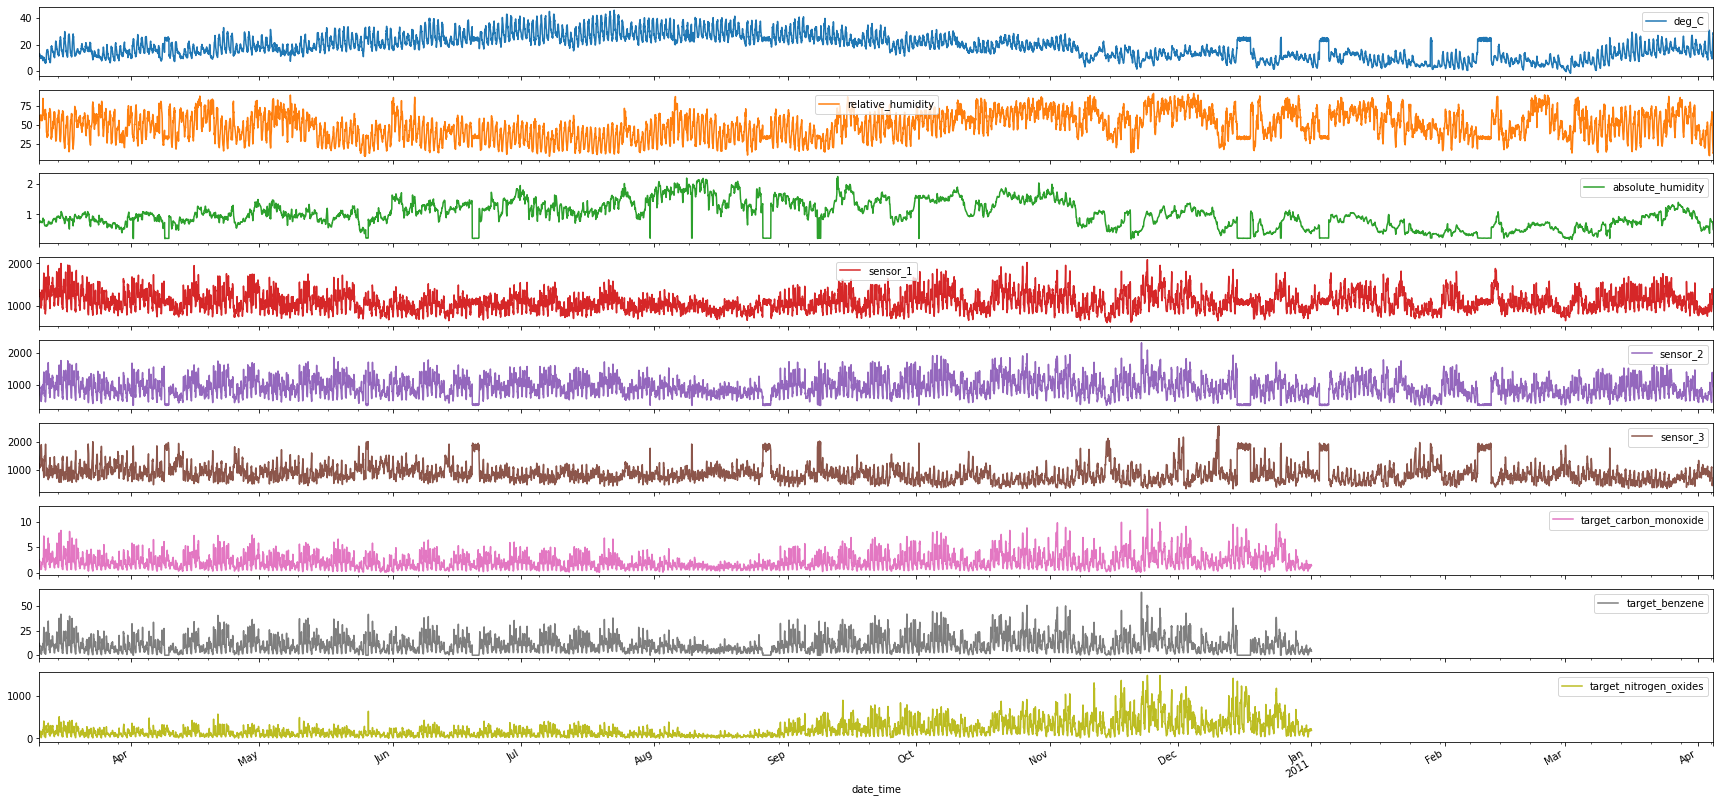

In [ ]:
date_time = pd.to_datetime(all_df['date_time'])
plot_cols = ['deg_C', 'relative_humidity', 'absolute_humidity', 'sensor_1', 'sensor_2', 'sensor_3', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
plot_features = all_df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(30,15))

plt.show()

# Data Preprocessing
1. Change the form of data to be feed to keras/tensorflow model
2. Split into training, validatoin, testing set

In [ ]:
# used as index later
date_time = pd.to_datetime(all_df.pop('date_time'))

In [ ]:
# move the target columns behind
cols_at_end = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
all_df = all_df[[c for c in all_df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in all_df]]

### Split the train data into train and validation set


In [ ]:
# length of training dataset
n = 7111

train_df = all_df.iloc[:n, :]

train_mean = train_df.mean()
train_std = train_df.std()

val_df = train_df[int(n*0.9):]
train_df = train_df[0:int(n*0.9)]
test_df = all_df.iloc[n:, :]


In [ ]:
# check if the dataset is divided correctly
train_df.shape[0] + val_df.shape[0]+ test_df.shape[0] == all_df.shape[0]

True

## Data Scaling/Normalization
### Future work: using moving average to scale the data?

In [ ]:
# train_mean = train_df.mean()
# train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# Data Windowing

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.all_columns = train_df.columns
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
      self.feature_columns = [a for a in self.all_columns if a not in self.label_columns] # this line is added by myself

    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    
    

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  """ 
  modification by myself
  """
  if self.feature_columns is not None:
    inputs = tf.stack(
        [inputs[:, :, self.column_indices[name]] for name in self.feature_columns],
        axis=-1)
  """
  until here
  """

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=100):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')


  checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model_2.h5", save_best_only=True)

  # lr_scheduler = keras.callbacks.LearningRateScheduler()
  lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10)



  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.002), # optimizer=tf.optimizers.Adam()
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val, verbose = 0,
                      callbacks=[early_stopping, checkpoint_cb, lr_scheduler])
  

  return history

In [ ]:
input_width=24
label_width=24
shift=1
label_columns = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
wide_window = WindowGenerator(input_width=input_width, label_width=label_width, label_columns=label_columns, shift=shift)
# wide_window = WindowGenerator(input_width=input_width, label_width=label_width, shift=shift)

In [ ]:
for example_inputs, example_labels in wide_window.val.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 8)
Labels shape (batch, time, features): (64, 24, 3)


## Stacked RNN

In [ ]:
num_features=3

gru_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.RNN(32, return_sequences=True, dropout=0.1),
    tf.keras.layers.RNN(32, return_sequences=True, dropout=0.1),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(gru_model, wide_window)

## Stacked LSTM

In [ ]:
num_features=3

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
    tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.1),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

<BatchDataset shapes: (None, None, 11), types: tf.float32>
22/22 [==============================] - 0s 8ms/step - loss: 1.0860 - mean_squared_error: 1.0860



## Stacked GRU

In [ ]:
num_features=3

gru_model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2),
    tf.keras.layers.GRU(64, return_sequences=True, dropout=0.2),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(gru_model, wide_window)

# IPython.display.clear_output()
# val_performance = gru_model.evaluate(wide_window.val)

# print()

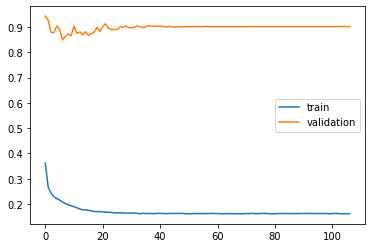

In [ ]:
# to check if underfit or overfit
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='right')

## Prediction

In [ ]:
gru_model = tf.keras.models.load_model("my_model_2.h5")

In [ ]:
test_X = test_df.iloc[:, :8]
test_X = np.array(test_X)
test_X = test_X.reshape(test_X.shape[0], 1, 8)

In [ ]:
preds = gru_model.predict(test_X)
preds = preds*np.array(train_std[-3:]) + np.array(train_mean[-3:])
preds.shape

(2246, 1, 3)

In [ ]:
date_time_reindex = date_time[7110:].reset_index(drop=True)

In [ ]:
take_from_train = pd.DataFrame(all_df.iloc[7110, 8:]).T

In [ ]:
submission = pd.DataFrame(preds.reshape(preds.shape[0],3), columns=label_columns)

In [ ]:
submission_extend = pd.concat([take_from_train, submission])
submission_extend = submission_extend.reset_index(drop=True)
submission_extend

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,1.400000,4.100000,186.500000
1,2.654256,12.992701,406.975359
2,2.014707,9.183967,302.793496
3,2.106809,9.583634,305.927555
4,1.546337,6.355734,217.171402
...,...,...,...
2242,3.209389,17.024260,362.432595
2243,2.397962,12.445748,256.376608
2244,2.371652,12.401036,243.554512
2245,1.772264,8.896447,176.752320


In [ ]:
submission_extend.describe()

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,2247.000000,2247.000000,2247.000000
mean,1.995450,8.998126,238.105387
std,1.123066,6.715174,154.146901
min,0.679651,0.566929,46.409193
25%,1.135915,3.536046,104.709650
50%,1.546337,6.704806,190.105360
75%,2.641191,13.171206,340.721066
max,5.457829,29.156921,660.204624


In [ ]:
final_submission = pd.concat([date_time_reindex, submission_extend], axis=1)
final_submission

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.400000,4.100000,186.500000
1,2011-01-01 01:00:00,2.654256,12.992701,406.975359
2,2011-01-01 02:00:00,2.014707,9.183967,302.793496
3,2011-01-01 03:00:00,2.106809,9.583634,305.927555
4,2011-01-01 04:00:00,1.546337,6.355734,217.171402
...,...,...,...,...
2242,2011-04-04 10:00:00,3.209389,17.024260,362.432595
2243,2011-04-04 11:00:00,2.397962,12.445748,256.376608
2244,2011-04-04 12:00:00,2.371652,12.401036,243.554512
2245,2011-04-04 13:00:00,1.772264,8.896447,176.752320


In [ ]:
final_submission.to_csv('51th_submission.csv', index=False)

In [ ]:
pd.read_csv('41th_submission.csv').describe()

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,2247.000000,2247.000000,2247.000000
mean,1.965095,8.534546,227.227481
std,1.165228,6.638482,139.016038
min,0.573326,0.557105,56.743614
25%,1.075712,3.092602,107.997837
50%,1.503463,6.262386,184.434525
75%,2.634394,12.636353,316.124558
max,5.532259,28.039197,605.598785
